<img src="../imgs/logo.png" width="20%" align="right" style="margin:0px 20px">


# Evolutionary Computation

## Evolution of Agents

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://d9w.github.io/evolution/">https://d9w.github.io/evolution/</a>

# Outline

1. [Reinforcement Learning](#rl)
2. [Evolving Agents](#evolving)
3. [Atari games](#atari)
4. [CGP](#cgp)
5. [Neuroevolution](#neuroevo)
6. [Comparison](#comparison)

In this project, you have been asked to evolve an agent to play a video game. In this notebook, we'll see an example of that as well as a brief explanation on agent evolution.

# <a id="rl"></a> Reinforcement Learning

The field of Reinforcement Learning provides a good framework for understanding the actions of an agent in an environment which rewards specific actions. There are many resources about RL online, including Emmanuel Rachelson's [class](https://github.com/erachelson/RLclass) which is taught in the SDD Master's program at Supaero. We'll look at a brief overview as it relates to evolution.

In RL, an agent acts based on a policy $\pi$,   which uses state information $S_t$ to take an action $A_t$. Based on this action, the environment rewards the agent $R_{t+1}$ and the agent moves into a new state $S_{t+1}$. 

<img src="../imgs/erl.png" width="35%">

The standard objective function for an evolutionary algorithm when applied to this problem is the sum total of the reward over all timesteps in an episode, from $t=0$ to the end of the episode $t=T$.

$$\sum_{t=0}^{t=T} R_{t}$$

In other words, evolution is aiming to maximize the total reward over all states $S$ observed and actions $A$ taken  during this episode. The set of states observed and actions taken depends on the current individual $\pi$ (or policy), where an action $a$ for a given state $s$ is determined by $a=\pi(s)$. A different way to write the objective function is:

$$\sum_{t=0}^{t=T} r(s_t, \pi(s_t))$$

where $r$ is the reward function of the problem. The optimization of the total reward over the entire episode is very different from Reinforcement Learning algorithms, which maximize the reward over individual state, action $(S,A)$ pairs and many of which aim to approximate $r$. In most evolutionary computation, all that matters is the total reward.

<div class="alert alert-warning">
    <h3>Reminder</h3>
    
In an evolutionary algorithm, the total reward is not the only fitness objective possible. Quality diversity algorithms like MAP-Elites use behavior metrics which measure a different objective than reward over an episode. Using total reward is a good way to compare evolutionary methods to Reinforcement Learning algorithms, but it is not the only option for evolutionary fitness functions.
</div>

# <a id="evolving"></a>Evolving Agents

When evolving agents, there are many options for representing the agent. The agent needs only to be able to taken an action $a$ at every step $s$, in other words the agent is $\pi$ and we'll use the agent to compute $a=\pi(s)$. Any representation of a function is possible: a layered artificial neural network where weights are optimized by evolution; a complex ANN where structure and weights are evolved; a genetic program; a gene regulatory network; any evolvable function representation works!

<img src="../imgs/agent_representations.png" width="50%">

The evaluation of an individual is therefore a multi-step process. Given an individual's genes $G$, a phenotype $P$ is computed. The genes can take many forms, as can the phenotypes. One example is a binary gene regulatory network, where binary genes encode protein tags which inform the weights of the final network, which is the phenotype. Another is the integer genotype used in NEAT, which encodes neurons and their connections in the phenotype which is a neural network.

<img src="../imgs/gene_pheno_behavior.png" width="70%">

 For evaluation, $P$ must be capable of representing a function $\pi$ which computes $a=\pi(s)$ or sometimes $a_t=\pi(s_t, r(s_{t-1}, a_{t-1}))$, where the reward from the previous step is also provided. The evaluation of the agent which informs its chances of passing on genetic information is then based on its behavior in a simulated environment.

In this notebook, we'll compare Cartesian Genetic Programming, where our agent is a function graph, and neuroevolution, using a $(1, \lambda)$ evolutionary strategy to evolve the weights of a 2 layer neural network. We'll use Atari games as the environment, specifically Ms. Pacman.

# <a id="atari"></a> Atari games

For a game environment, we'll use the [Arcade Learning Environment](https://github.com/mgbellemare/Arcade-Learning-Environment), which allows us to emulate and manipulate Atari games. There is a [Julia wrapper](https://github.com/JuliaReinforcementLearning/ArcadeLearningEnvironment.jl) which I've only tested on Linux, although the [atari-py](https://github.com/openai/atari-py) package mentions Windows support

In [4]:
using Pkg
pkg"add ArcadeLearningEnvironment"

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
Precompiling project...
  ✓ NSGA2CGP
  1 dependency successfully precompiled in 1 seconds (257 already precompiled)


This package automatically installs a number of ROMs from the `atari-py` repository

In [5]:
using ArcadeLearningEnvironment
ale = ALE_new()

A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.


Ptr{Nothing} @0x000000000485d150

In [6]:
getROMList()

74-element Vector{String}:
 "air_raid"
 "alien"
 "amidar"
 "assault"
 "asterix"
 "asteroids"
 "atlantis"
 "bank_heist"
 "battle_zone"
 "beam_rider"
 "berzerk"
 "bowling"
 "boxing"
 ⋮
 "star_gunner"
 "surround"
 "tennis"
 "time_pilot"
 "trondead"
 "tutankham"
 "up_n_down"
 "venture"
 "video_pinball"
 "wizard_of_wor"
 "yars_revenge"
 "zaxxon"

We'll look at  Ms. Pacman as an example. Instead of using the entire action set, we'll only use the actions available in this game. Since the "fire" button isn't used in Ms. Pacman, the only actions are the 8 directions from the joystick and no input.

In [7]:
loadROM(ale, "ms_pacman")
actions = getMinimalActionSet(ale)

Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0


9-element Vector{Int64}:
 0
 2
 3
 4
 5
 6
 7
 8
 9

Let's see what the environment looks like.

In [61]:
using Images, ImageView
function get_screen(ale)
    screen = reshape(getScreenRGB(ale), (3, getScreenWidth(ale), getScreenHeight(ale))) ./ 256
    colorview(RGB, permutedims(screen, [1, 3, 2]))
end

┌ Info: Precompiling ImageView [86fae568-95e7-573e-a6b2-d8a6b900c9ef]
└ @ Base loading.jl:1423
┌ Warning: Module IntervalSets with build ID 13126541114611 is missing from the cache.
│ This may mean IntervalSets [8197267c-284f-5f27-9208-e0e47529a953] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module IntervalSets with build ID 13126541114611 is missing from the cache.
│ This may mean IntervalSets [8197267c-284f-5f27-9208-e0e47529a953] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Info: Skipping precompilation since __precompile__(false). Importing ImageView [86fae568-95e7-573e-a6b2-d8a6b900c9ef].
└ @ Base loading.jl:1124
┌ Info: Precompiling GtkReactive [27996c0f-39cd-5cc1-a27a-05f136f946b6]
└ @ Base loading.jl:1423
┌ Warning: Module IntervalSets with build ID 13126541114611 is missing from the cache.
│ This may mean IntervalSets [8197267c-284f-5f27-9208-e0e47529a953] does 

get_screen (generic function with 1 method)

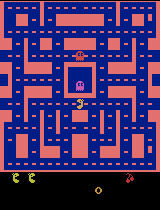

┌ Info: Precompiling PNGFiles [f57f5aa1-a3ce-4bc8-8ab9-96f992907883]
└ @ Base loading.jl:1423


In [62]:
get_screen(ale)

Let's watch the environment as our agent takes random actions.

In [63]:
using Reel
Reel.set_output_type("gif");

In [64]:
loadROM(ale, "ms_pacman")
frames = Frames(MIME("image/png"), fps=60)
total_reward = 0
while ~game_over(ale)
    total_reward += act(ale, rand(actions))
    push!(frames, get_screen(ale))
end
reset_game(ale)

Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0


In [65]:
frames

Frames{MIME{Symbol("image/png")}}("/tmp/jl_UWZhfl", 0x0000000000000751, 60.0, nothing)

For the state of our environment, we have two options: the pixels, as we saw in the [class on CGP](https://d9w.github.io/evolution/4_gp/2_cgp.html), and the RAM, the memory of the game. We'll use the RAM in this example since it is much smaller and evolution will be faster since we don't need to get the screen every step.

In [66]:
loadROM(ale, "ms_pacman")

Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0


In [67]:
getRAM(ale)

128-element Vector{UInt8}:
 0x00
 0x70
 0x72
 0x73
 0x00
 0x03
 0x58
 0x58
 0x58
 0x58
 0x58
 0x00
 0x50
    ⋮
 0x00
 0x3f
 0x00
 0x00
 0x00
 0x00
 0x00
 0x02
 0x42
 0xf0
 0x92
 0xd7

# <a id="cgp"></a>CGP

Let's evolve our first agent. We'll use `Cambrian.jl` and `CartesianGeneticProgramming.jl` to evolve a function graph using CGP which takes in the RAM values and outputs a value per action, which we'll use the maximum of to determine the action at each step.

In [68]:
pkg"add https://github.com/d9w/Cambrian.jl"
pkg"add https://github.com/d9w/CartesianGeneticProgramming.jl"

    Updating git-repo `https://github.com/d9w/Cambrian.jl`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
Precompiling project...
  ✓ NSGA2CGP
  1 dependency successfully precompiled in 1 seconds (284 already precompiled)
    Updating git-repo `https://github.com/d9w/CartesianGeneticProgramming.jl`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
Precompiling project...
  ✓ NSGA2CGP
  1 dependency successfully precompiled in 1 seconds (284 already precompiled)


In [69]:
using Cambrian
using CartesianGeneticProgramming

An example configuration for CGP on this problem is provided in `atari.yaml`. This specifies which functions CGP can choose from, how many rows and columns there are, and what the mutation rate is.

In [70]:
cfg = get_config("atari.yaml"; n_in=length(getRAM(ale)), n_out=length(actions), n_parameters=0, recur=0)
cfg

(two_arity = Bool[1, 1, 1, 0, 0, 0, 1, 1], n_in = 128, m_rate = 0.1, functions = Function[CartesianGeneticProgramming.CGPFunctions.f_add, CartesianGeneticProgramming.CGPFunctions.f_subtract, CartesianGeneticProgramming.CGPFunctions.f_mult, CartesianGeneticProgramming.CGPFunctions.f_abs, CartesianGeneticProgramming.CGPFunctions.f_exp, CartesianGeneticProgramming.CGPFunctions.f_sin, CartesianGeneticProgramming.CGPFunctions.f_lt, CartesianGeneticProgramming.CGPFunctions.f_gt], n_parameters = 0, recur = 0, d_fitness = 1, save_gen = 10, out_m_rate = 0.3, n_out = 9, id = "2022-04-14T13:35:07.876", n_elite = 1, n_population = 5, rows = 3, n_gen = 1000, seed = 0, columns = 100, log_gen = 1)

We'll define our objective function allowing us to also use this function to visualize an agent as it plays.

In [100]:
cgp_fits = []
function play_atari(ind::CGPInd; render=false, seed=0)
    ale = ALE_new()
    setInt(ale, "random_seed", 0)
    loadROM(ale, "ms_pacman")
    if render
        frames = Frames(MIME("image/png"), fps=6)
    end
    f = 0
    total_reward = 0
    while ~game_over(ale) && f < 18000
        inputs = getRAM(ale) ./ typemax(UInt8)
        output = process(ind, inputs)
        total_reward += act(ale, actions[argmax(output)])
        if render && mod(f, 10) == 0
            push!(frames, get_screen(ale))
        end
        f += 1
    end
    ALE_del(ale)
    if render
        return total_reward, frames
    end
    push!(cgp_fits, total_reward)
    [total_reward]
end

play_atari (generic function with 1 method)

Let's see how a random individual does

In [102]:
ind = CGPInd(cfg);
@timev total_reward, frames = play_atari(ind; render=true)

  0.593313 seconds (1.12 M allocations: 519.295 MiB, 2.90% gc time)
elapsed time (ns): 593312628
gc time (ns):      17208383
bytes allocated:   544519888
pool allocs:       1119871
malloc() calls:    1098
GC pauses:         5


A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0


(180, Frames{MIME{Symbol("image/png")}}("/tmp/jl_dUyBfV", 0x00000000000000b7, 6.0, nothing))

In [103]:
frames

Frames{MIME{Symbol("image/png")}}("/tmp/jl_dUyBfV", 0x00000000000000b7, 6.0, nothing)

The rendering evaluation took a while if we consider that during evolution, we'll run this function hundreds or thousands of times. Let's see how long it takes without rendering.

In [104]:
@timev total_reward = play_atari(ind)

  0.342677 seconds (1.11 M allocations: 43.554 MiB)
elapsed time (ns): 342677158
bytes allocated:   45670032
pool allocs:       1107788


A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0


1-element Vector{Int64}:
 180

That's better. Let's run the evolution for 20 generations, evaluating 5 individuals each time ($\lambda$=5) for a total of 100 evaluations.

In [105]:
cgp_fits = []
e = CGPEvolution(cfg, play_atari);

In [106]:
function mutate(i::CGPInd)
    goldman_mutate(cfg, i)
end

mutate (generic function with 1 method)

In [107]:
for i in 1:40
    e.gen += 1
    if e.gen > 1
        p1 = Cambrian.max_selection(e.population)
        print(e.gen, ": ", p1.fitness)
        e.population[1] = p1
        for i in 2:e.config.n_population
            e.population[i] = goldman_mutate(cfg, p1)
        end
    end
    Cambrian.evaluate(e)
    Cambrian.log_gen(e)
end

A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0
A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_nam

A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0
A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_nam

A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0
A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_nam

A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0
A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_nam

A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0
A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_nam

A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0
A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_nam

A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0
A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_nam

A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0
A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_nam

A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0
A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_nam

A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0
A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_nam

2: [210.0]3: [210.0]4: [650.0]5: [1040.0]6: [1040.0]7: [1040.0]8: [1040.0]9: [1040.0]10: [1040.0]11: [1040.0]12: [1040.0]13: [1040.0]14: [1040.0]15: [1040.0]16: [1040.0]17: [1040.0]18: [1040.0]19: [1040.0]20: [1040.0]21: [1040.0]22: [1040.0]23: [1040.0]24: [1040.0]25: [1040.0]26: [1040.0]27: [1040.0]28: [1040.0]29: [1040.0]30: [1040.0]31: [1040.0]32: [1040.0]33: [1040.0]34: [1040.0]35: [1040.0]36: [1040.0]37: [1040.0]38: [1040.0]39: [1040.0]40: [1040.0]

Let's observe the best individual from evolution and display its actions.

In [110]:
best = sort(e.population)[end];
total_reward, frames = play_atari(best, render=true)

A.L.E: Arcade Learning Environment (version 0.6.0)
[Powered by Stella]
Use -help for help screen.
Game console created:
  ROM file:  /home/d9w/.julia/artifacts/9b7774e2f34581dc08d0979a8172c6d157be1f2d/ms_pacman.bin
  Cart Name: Ms. Pac-Man (1982) (Atari)
  Cart MD5:  87e79cd41ce136fd4f72cc6e2c161bee
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        8192
  Bankswitch Type: AUTO-DETECT ==> F8


Cartridge_MD5: 87e79cd41ce136fd4f72cc6e2c161bee
Cartridge_name: Ms. Pac-Man (1982) (Atari)

Running ROM file...
Random seed is 0


(1040, Frames{MIME{Symbol("image/png")}}("/tmp/jl_TdkSef", 0x0000000000000139, 6.0, nothing))

In [111]:
frames

Frames{MIME{Symbol("image/png")}}("/tmp/jl_TdkSef", 0x0000000000000139, 6.0, nothing)